# Complejidad de los datos

### Introducción

En esta sesión analizaremos el tema de complejidad de los datos y algunas técnicas para tratar los efectos de la misma. Este cuaderno se basa parcialmente en el material del curso de limpieza de datos de Kaggle disponible [aquí](https://www.kaggle.com/learn/data-cleaning).

### Gestión de valores omitidos
Elimine los valores que faltan o rellénelos con un flujo de trabajo automatizado.

La limpieza de datos es una parte clave de la ciencia de datos, pero puede ser muy frustrante. ¿Por qué hay campos de texto ilegibles? ¿Qué hacer con los valores que faltan? ¿Por qué las fechas no tienen el formato correcto? ¿Cómo puede solucionar rápidamente la introducción de datos incoherentes? En este tema, aprenderá por qué se ha encontrado con estos problemas y, lo que es más importante, cómo solucionarlos.

En este cuaderno, aprenderá a abordar algunos de los problemas más comunes de limpieza de datos para que pueda analizar sus datos más rápidamente. Realizará cinco ejercicios prácticos con datos reales y desordenados y responderá a algunas de las preguntas más frecuentes sobre la limpieza de datos.

En este cuaderno, veremos cómo tratar los valores faltantes u omitidos.

#### Primer vistazo a los datos

Lo primero que tenemos que hacer es cargar las bibliotecas y el conjunto de datos que vamos a utilizar.

Para la demostración, utilizaremos un conjunto de datos de eventos ocurridos en partidos de fútbol americano. Debido al tamaño del conjunto de datos, lo descargaremos y posteriormente lo cargaremos a nuestro espacio temporal. [Ir a la página de descarga](https://www.kaggle.com/code/alexisbcook/handling-missing-values/data?select=NFL+Play+by+Play+2009-2017+%28v4%29.csv).

In [1]:
# módulos que usaremos
import pandas as pd
import numpy as np

# cargamos los datos
nfl_data = pd.read_csv("NFL Play by Play 2009-2017 (v4).csv")

# fijamos la semilla para reproducibilidad
np.random.seed(0)

<ipython-input-1-c38b21acee8e>:6: DtypeWarning: Columns (25,51) have mixed types. Specify dtype option on import or set low_memory=False.
  nfl_data = pd.read_csv("NFL Play by Play 2009-2017 (v4).csv")


Lo primero que hay que hacer cuando se recibe un nuevo conjunto de datos es echar un vistazo a algunos de ellos. Esto nos permite ver que todo se lee correctamente y nos da una idea de lo que está pasando con los datos. En este caso, vamos a ver si hay valores perdidos u omitidos, que son representados en Python con `NaN`.

In [2]:
nfl_data.head()

,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,SideofField,...,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
0,2009-09-10,2009091000,1,1,NaN,15:00,15,3600.0,0.0,TEN,...,NaN,0.485675,0.514325,0.546433,0.453567,0.485675,0.060758,NaN,NaN,2009
1,2009-09-10,2009091000,1,1,1.0,14:53,15,3593.0,7.0,PIT,...,1.146076,0.546433,0.453567,0.551088,0.448912,0.546433,0.004655,-0.032244,0.036899,2009
2,2009-09-10,2009091000,1,1,2.0,14:16,15,3556.0,37.0,PIT,...,NaN,0.551088,0.448912,0.510793,0.489207,0.551088,-0.040295,NaN,NaN,2009
3,2009-09-10,2009091000,1,1,3.0,13:35,14,3515.0,41.0,PIT,...,-5.031425,0.510793,0.489207,0.461217,0.538783,0.510793,-0.049576,0.106663,-0.156239,2009
4,2009-09-10,2009091000,1,1,4.0,13:27,14,3507.0,8.0,PIT,...,NaN,0.461217,0.538783,0.558929,0.441071,0.461217,0.097712,NaN,NaN,2009


¿Observamos datos faltantes?

¿Cuántos puntos de datos faltantes tenemos?

Bien, ahora sabemos que tenemos algunos valores faltantes. Veamos cuántos tenemos en cada columna.

In [3]:
# obtenemos el número de datos faltantes por columna
missing_values_count = nfl_data.isnull().sum()

# Revisamos el número de datos faltantes en las primeras 10 columnas del conjunto de datos (tiene 102 columnas en total).
missing_values_count[0:10]

Date                0
GameID              0
Drive               0
qtr                 0
down            61154
time              224
TimeUnder           0
TimeSecs          224
PlayTimeDiff      444
SideofField       528
dtype: int64

¿Qué opinas de los resultados mostrados? Sería útil saber qué porcentaje de valores faltan en nuestro conjunto de datos para hacernos una idea más precisa de la magnitud del problema:

In [6]:
print(nfl_data.shape)
a,b = nfl_data.shape
print(a)
print(b)
print(a*b)

(407688, 102)
407688
102
41584176


In [7]:
# ¿Cuántos valores faltantes tenemos en total en el conjunto datos?
print(nfl_data.shape)
total_cells = np.product(nfl_data.shape)
total_missing = missing_values_count.sum()

# porcentaje de datos faltante
percent_missing = (total_missing/total_cells) * 100
print(f'Celdas totales: {total_cells:,}')   # Se agrega :, a la derecha de la variable para dar formato de miles
print(f'Celdas con datos faltantes: {total_missing:,}') # Se agrega :, a la derecha de la variable para dar formato de miles
print(f'Porcentaje de datos faltantes: {round(percent_missing,2)}%')

(407688, 102)
Celdas totales: 41,584,176
Celdas con datos faltantes: 10,342,875
Porcentaje de datos faltantes: 24.87%


¿Qué opinas del porcentaje de datos faltantes?

#### Averiguar por qué faltan datos

Este es el punto en el que entramos en la parte de la ciencia de datos que solemos llamar "intuición de datos", es decir, "analizar realmente los datos e intentar averiguar por qué son como son y cómo afectarán a nuestro análisis". Puede ser una parte frustrante de la ciencia de datos, especialmente si eres nuevo en este campo y no tienes mucha experiencia. Para tratar los valores que faltan, tendrás que usar tu intuición para averiguar por qué falta el valor. Una de las preguntas más importantes que puede hacerse para averiguarlo es la siguiente:

**¿Este valor falta porque no se registró o porque no existe?**

Si falta un valor porque no existe (como la altura del hijo mayor de alguien que no tiene hijos), no tiene sentido intentar adivinar cuál podría ser. Estos valores probablemente quieras mantenerlos como NaN. Por otro lado, si falta un valor porque no se registró, puede intentar adivinar cuál podría haber sido basándose en los demás valores de esa columna y fila. Esto se llama imputación, ¡y aprenderemos a hacerlo a continuación! :)

Veamos un ejemplo. Observando el número de valores faltantes en el marco de datos nfl_data, nos damos cuenta de que la columna "TimeSecs" tiene muchos valores faltantes:

In [8]:
# Revisamos el número de datos faltantes en las primeras 10 columnas del conjunto de datos (tiene 102 columnas en total).
missing_values_count[0:10]

Date                0
GameID              0
Drive               0
qtr                 0
down            61154
time              224
TimeUnder           0
TimeSecs          224
PlayTimeDiff      444
SideofField       528
dtype: int64

Revisando la documentación, podemos ver que esta columna tiene información sobre el número de segundos que quedaban en el partido cuando se hizo la jugada. Esto significa que estos valores probablemente faltan porque no se registraron, y no porque no existan. Por lo tanto, tendría sentido que intentáramos adivinar cuáles deberían ser en lugar de dejarlos como `NaN`.

Por otra parte, hay otros campos, como "PenalizedTeam", en los que también faltan muchos campos. En este caso, sin embargo, el campo falta porque si no hubo penalización no tiene sentido decir qué equipo fue penalizado. Para esta columna, tendría más sentido dejarla vacía o añadir un tercer valor como "ninguno" y utilizarlo para reemplazar los `NaN`.

Si está realizando un análisis de datos muy cuidadoso, este es el punto en el que miraría cada columna individualmente para averiguar cuál es la mejor estrategia para rellenar los valores que faltan. En el resto de este cuaderno, trataremos algunas técnicas "rápidas y sucias" que pueden ayudarle con los valores que faltan, pero que probablemente acabarán eliminando información útil o añadiendo ruido a los datos.

#### Eliminar valores faltantes
Si tiene prisa o no tiene motivos para averiguar por qué faltan valores, una opción es eliminar las filas o columnas que contengan valores que falten. (Nota: ¡generalmente no se recomienda este enfoque para proyectos importantes! Suele merecer la pena tomarse el tiempo necesario para revisar los datos y examinar una por una todas las columnas con valores faltantes para conocer realmente el conjunto de datos).

Si está seguro de que quiere eliminar las filas con valores faltantes, pandas tiene una función muy útil, dropna() para ayudarle a hacerlo. Vamos a probarla en nuestro conjunto de datos de la NFL.

In [9]:
# eliminar todos los renglones que contengan un valor faltante u omitido
nfl_data.dropna()

,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,SideofField,...,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season


¿Qué sucedió? ¡parece que se han eliminado todos nuestros datos! 😱 Esto se debe a que cada fila de nuestro conjunto de datos tenía al menos un valor faltante. Podríamos tener mejor suerte eliminando todas las columnas que tienen al menos un valor faltante en su lugar.

In [12]:
# Eliminemos ahora todas las columnas en donde exista un valor faltante
columns_with_na_dropped = nfl_data.dropna(axis=1) #Al agregar el parámetro axis=1 estamos indicando que el criterio sea revisar columnas. Por defecto se revisan renglones (axis=0)
columns_with_na_dropped.head(10)

,Date,GameID,Drive,qtr,TimeUnder,ydstogo,ydsnet,PlayAttempted,Yards.Gained,sp,...,Timeout_Indicator,Timeout_Team,posteam_timeouts_pre,HomeTimeouts_Remaining_Pre,AwayTimeouts_Remaining_Pre,HomeTimeouts_Remaining_Post,AwayTimeouts_Remaining_Post,ExPoint_Prob,TwoPoint_Prob,Season
0,2009-09-10,2009091000,1,1,15,0,0,1,39,0,...,0,None,3,3,3,3,3,0.0,0.0,2009
1,2009-09-10,2009091000,1,1,15,10,5,1,5,0,...,0,None,3,3,3,3,3,0.0,0.0,2009
2,2009-09-10,2009091000,1,1,15,5,2,1,-3,0,...,0,None,3,3,3,3,3,0.0,0.0,2009
3,2009-09-10,2009091000,1,1,14,8,2,1,0,0,...,0,None,3,3,3,3,3,0.0,0.0,2009
4,2009-09-10,2009091000,1,1,14,8,2,1,0,0,...,0,None,3,3,3,3,3,0.0,0.0,2009
5,2009-09-10,2009091000,2,1,14,10,0,1,0,0,...,0,None,3,3,3,3,3,0.0,0.0,2009
6,2009-09-10,2009091000,2,1,13,10,4,1,4,0,...,0,None,3,3,3,3,3,0.0,0.0,2009
7,2009-09-10,2009091000,2,1,13,6,2,1,-2,0,...,0,None,3,3,3,3,3,0.0,0.0,2009
8,2009-09-10,2009091000,2,1,12,8,2,1,11,0,...,0,None,3,3,3,3,3,0.0,0.0,2009
9,2009-09-10,2009091000,3,1,12,10,3,1,3,0,...,0,None,3,3,3,3,3,0.0,0.0,2009


In [13]:
columns_with_na_dropped.shape

(407688, 41)

In [19]:
#a, b = nfl_data.shape
a = nfl_data.shape[0]
b = nfl_data.shape[1]
print(a)
print(b)

407688
102


Calcular cuanta información hemos perdido

In [20]:
print(f"Columnas en el conjunto de datos original: {nfl_data.shape[1]}")
print(f"Columnas restantes tras eliminar datos faltantes: {columns_with_na_dropped.shape[1]}")
print(f"Total de columnas eliminadas: {nfl_data.shape[1] - columns_with_na_dropped.shape[1]}")

Columnas en el conjunto de datos original: 102
Columnas restantes tras eliminar datos faltantes: 41
Total de columnas eliminadas: 61


#### Rellenar automáticamente los valores que faltan
Otra opción es intentar rellenar los valores que faltan. Para ello, vamos a tomar una pequeña subsección de los datos de la NFL para que se imprima bien.

In [21]:
# obtenemos un pequeño subconjunto del conjunto de datos de la NFL
subset_nfl_data = nfl_data.loc[:, 'EPA':'Season'].head()
subset_nfl_data

,EPA,airEPA,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
0,2.014474,NaN,NaN,0.485675,0.514325,0.546433,0.453567,0.485675,0.060758,NaN,NaN,2009
1,0.077907,-1.068169,1.146076,0.546433,0.453567,0.551088,0.448912,0.546433,0.004655,-0.032244,0.036899,2009
2,-1.402760,NaN,NaN,0.551088,0.448912,0.510793,0.489207,0.551088,-0.040295,NaN,NaN,2009
3,-1.712583,3.318841,-5.031425,0.510793,0.489207,0.461217,0.538783,0.510793,-0.049576,0.106663,-0.156239,2009
4,2.097796,NaN,NaN,0.461217,0.538783,0.558929,0.441071,0.461217,0.097712,NaN,NaN,2009


Podemos utilizar la función fillna() de Panda para que rellene por nosotros los valores que faltan en un marco de datos. Una opción que tenemos es especificar con qué queremos que se sustituyan los valores NaN. Aquí, estoy diciendo que me gustaría reemplazar todos los valores NaN con 0.

In [22]:
# remplazar todos los datos NaN con 0
subset_nfl_data.fillna(0)

,EPA,airEPA,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
0,2.014474,0.000000,0.000000,0.485675,0.514325,0.546433,0.453567,0.485675,0.060758,0.000000,0.000000,2009
1,0.077907,-1.068169,1.146076,0.546433,0.453567,0.551088,0.448912,0.546433,0.004655,-0.032244,0.036899,2009
2,-1.402760,0.000000,0.000000,0.551088,0.448912,0.510793,0.489207,0.551088,-0.040295,0.000000,0.000000,2009
3,-1.712583,3.318841,-5.031425,0.510793,0.489207,0.461217,0.538783,0.510793,-0.049576,0.106663,-0.156239,2009
4,2.097796,0.000000,0.000000,0.461217,0.538783,0.558929,0.441071,0.461217,0.097712,0.000000,0.000000,2009


Quizás una mejor estrategia sea sustituir los valores que faltan por cualquier valor que le siga directamente en la misma columna. (Esto tiene mucho sentido para conjuntos de datos en los que las observaciones tienen algún tipo de orden lógico).

In [23]:
# reemplazar todos los NaN con el valor que viene directamente después de él en la misma columna
# y sustituir todos los NaN restantes por 0
subset_nfl_data.fillna(method='bfill', axis=0).fillna(0)

,EPA,airEPA,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
0,2.014474,-1.068169,1.146076,0.485675,0.514325,0.546433,0.453567,0.485675,0.060758,-0.032244,0.036899,2009
1,0.077907,-1.068169,1.146076,0.546433,0.453567,0.551088,0.448912,0.546433,0.004655,-0.032244,0.036899,2009
2,-1.402760,3.318841,-5.031425,0.551088,0.448912,0.510793,0.489207,0.551088,-0.040295,0.106663,-0.156239,2009
3,-1.712583,3.318841,-5.031425,0.510793,0.489207,0.461217,0.538783,0.510793,-0.049576,0.106663,-0.156239,2009
4,2.097796,0.000000,0.000000,0.461217,0.538783,0.558929,0.441071,0.461217,0.097712,0.000000,0.000000,2009


Opciones para el parámetro `method`:

**ffill**

Rellenar valores propagando la última observación válida a la siguiente válida.

**bfill**

Rellenar valores utilizando la siguiente observación válida para rellenar el hueco.

In [24]:
# reemplazar todos los NaN con el valor que viene directamente antes de él en la misma columna
# y sustituir todos los NaN restantes por 0
subset_nfl_data.fillna(method='ffill', axis=0).fillna(0)

,EPA,airEPA,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
0,2.014474,0.000000,0.000000,0.485675,0.514325,0.546433,0.453567,0.485675,0.060758,0.000000,0.000000,2009
1,0.077907,-1.068169,1.146076,0.546433,0.453567,0.551088,0.448912,0.546433,0.004655,-0.032244,0.036899,2009
2,-1.402760,-1.068169,1.146076,0.551088,0.448912,0.510793,0.489207,0.551088,-0.040295,-0.032244,0.036899,2009
3,-1.712583,3.318841,-5.031425,0.510793,0.489207,0.461217,0.538783,0.510793,-0.049576,0.106663,-0.156239,2009
4,2.097796,3.318841,-5.031425,0.461217,0.538783,0.558929,0.441071,0.461217,0.097712,0.106663,-0.156239,2009


### Escalado y Normalización
Transformar variables numéricas para que tengan propiedades útiles.

#### Cargamos los módulos a utilizar

In [26]:
%pip install mlxtend

In [27]:
# módulos a utilizar
import pandas as pd
import numpy as np

# para transformación Box-Cox
from scipy import stats

# para escalado min_max
from mlxtend.preprocessing import minmax_scaling

# módulos de visualización
import seaborn as sns
import matplotlib.pyplot as plt

# fijamos la semilla para reproducibilidad
np.random.seed(0)

#### Escalado frente a normalización: ¿Cuál es la diferencia?

Una de las razones por las que es fácil confundirse entre escalado y normalización es porque los términos a veces se utilizan indistintamente y, para hacerlo aún más confuso, ¡son muy similares! En ambos casos, se transforman los valores de las variables numéricas para que los puntos de datos transformados tengan propiedades útiles específicas. La diferencia es que en el escalado, se cambia el rango de los datos, mientras que en la normalización, cambia la forma de la distribución de los datos.

Hablemos un poco más en profundidad de cada una de estas opciones.

#### Escalado

Esto significa que está transformando sus datos para que se ajusten a una escala específica, como 0-100 o 0-1. Es conveniente escalar los datos cuando se utilizan métodos basados en medidas de la distancia entre los puntos de datos, como las máquinas de vectores de soporte (SVM) o los vecinos más cercanos (KNN). Con estos algoritmos, un cambio de "1" en cualquier característica numérica recibe la misma importancia.

Por ejemplo, puede consultar los precios de algunos productos en yenes y en dólares estadounidenses. Un dólar estadounidense vale unos 100 yenes, pero si no escala los precios, métodos como SVM o KNN considerarán que una diferencia de precio de 1 yen es tan importante como una diferencia de 1 dólar estadounidense. Está claro que esto no encaja con nuestras intuiciones del mundo. Con la divisa, puedes convertir entre divisas. Pero, ¿qué ocurre con la altura y el peso? No está del todo claro cuántas libras equivalen a una pulgada (o cuántos kilogramos equivalen a un metro).

Al escalar las variables, puedes comparar diferentes variables en igualdad de condiciones. Para ayudarte a entender cómo es el escalado, veamos un ejemplo inventado. (No te preocupes, en el siguiente ejercicio trabajaremos con datos reales).

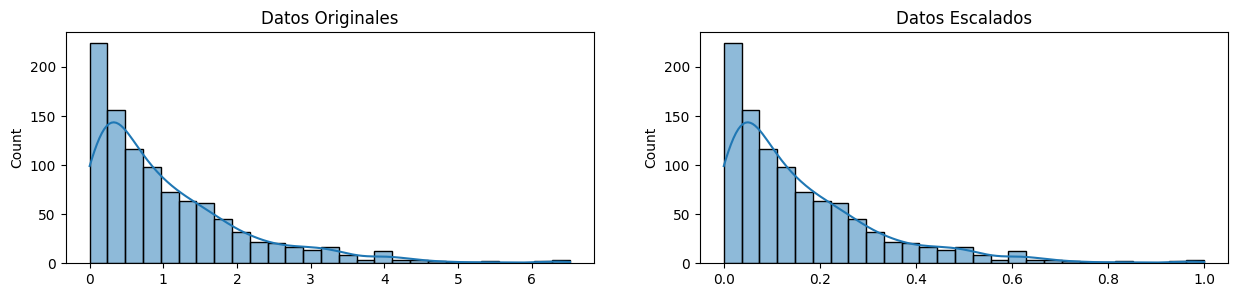

In [29]:
# generar 1000 puntos de datos extraídos aleatoriamente de una distribución exponencial
original_data = np.random.exponential(size=1000)

# mix-max escala los datos entre 0 y 1
scaled_data = minmax_scaling(original_data, columns=[0])

# graficamos ambos para comparar
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
sns.histplot(original_data, ax=ax[0], kde=True, legend=False)
ax[0].set_title("Datos Originales")
sns.histplot(scaled_data, ax=ax[1], kde=True, legend=False)
ax[1].set_title("Datos Escalados")
plt.show()

Observe que la forma de los datos no cambia, pero que en lugar de ir de 0 a 8, ahora van de 0 a 1.

#### Normalización
El escalado sólo cambia el rango de los datos. La normalización es una transformación más radical. El objetivo de la normalización es cambiar las observaciones para que puedan describirse como una distribución normal.

[Distribución normal](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_normal): También conocida como "curva de campana", es una distribución estadística específica en la que aproximadamente el mismo número de observaciones se sitúan por encima y por debajo de la media, la media y la mediana son iguales y hay más observaciones cerca de la media. La distribución normal también se conoce como distribución de Gauss.

En general, normalizará sus datos si va a utilizar una técnica de aprendizaje automático o estadística que asuma que sus datos se distribuyen normalmente. Algunos ejemplos son el análisis discriminante lineal (LDA) y el Bayes ingenuo gaussiano. (Consejo profesional: cualquier método con "gaussiano" en el nombre probablemente asume la normalidad).

El método que estamos utilizando para normalizar aquí se llama Transformación [Box-Cox](https://en.wikipedia.org/wiki/Power_transform#Box%E2%80%93Cox_transformation). Echemos un vistazo rápido a cómo se ve la normalización de algunos datos:

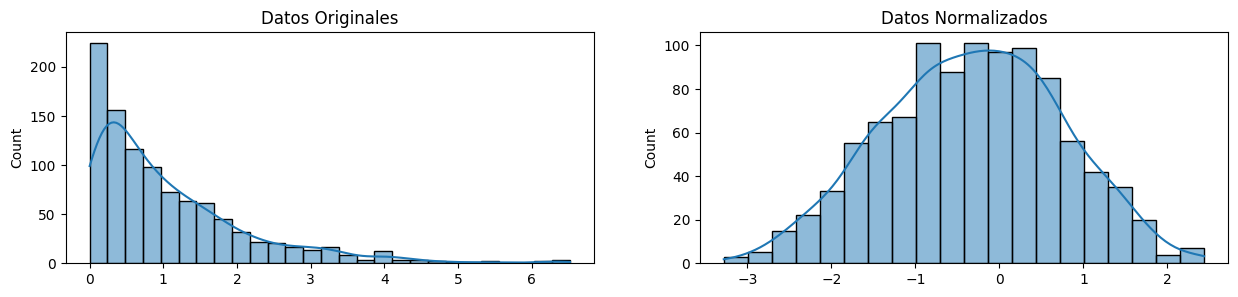

In [30]:
# normalizar los datos exponenciales con boxcox
normalized_data = stats.boxcox(original_data)

# graficamos ambos para comparar
fig, ax=plt.subplots(1, 2, figsize=(15, 3))
sns.histplot(original_data, ax=ax[0], kde=True, legend=False)
ax[0].set_title("Datos Originales")
sns.histplot(normalized_data[0], ax=ax[1], kde=True, legend=False)
ax[1].set_title("Datos Normalizados")
plt.show()

Observe que la forma de nuestros datos ha cambiado. Antes de la normalización tenían casi forma de L. Pero después de la normalización se parecen más al contorno de una campana (de ahí lo de "curva de campana").